In [26]:
# import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller

In [2]:
# import dataframe from data-analysis folder that has the label_encoded genres and year feature
df = pd.read_csv(r'/Users/adityamxr/Desktop/spotify-time-series/data-analysis/label_encoded_streams_df.csv')

In [3]:
# verify import
df.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,cleaned_broad_genre,labelenc_genre
0,0.995,0.708,158648,0.1950,0,0.563,0.1510,-12.428,1,0,0.0506,118.469,0.7790,1928,unknown,500
1,0.994,0.379,282133,0.0135,0,0.901,0.0763,-28.454,1,0,0.0462,83.972,0.0767,1928,early music,138
2,0.604,0.749,104300,0.2200,0,0.000,0.1190,-19.924,0,0,0.9290,107.177,0.8800,1928,epicore,149
3,0.995,0.781,180760,0.1300,0,0.887,0.1110,-14.734,0,0,0.0926,108.003,0.7200,1928,tango,477
4,0.990,0.210,687733,0.2040,0,0.908,0.0980,-16.829,1,1,0.0424,62.149,0.0693,1928,classical,96


#### Remove cleaned_broad_genre, and all features except the top 4 features: Explicit, Acousticness, Loudness, Labelenc_genre

In [4]:
features_to_remove = ['danceability', 'duration_ms','energy', 'instrumentalness', 'liveness', 'mode','speechiness','tempo','valence','cleaned_broad_genre','popularity']

df = df.drop(columns=features_to_remove)
# set 'year' as the index since this will be the time modularity
df.set_index('year', inplace=True)
# verify df
df.head()

,acousticness,explicit,loudness,labelenc_genre
year,,,,
1928,0.995,0,-12.428,500
1928,0.994,0,-28.454,138
1928,0.604,0,-19.924,149
1928,0.995,0,-14.734,477
1928,0.990,0,-16.829,96


#### Plot the line graphs of each feature with year as the modularity

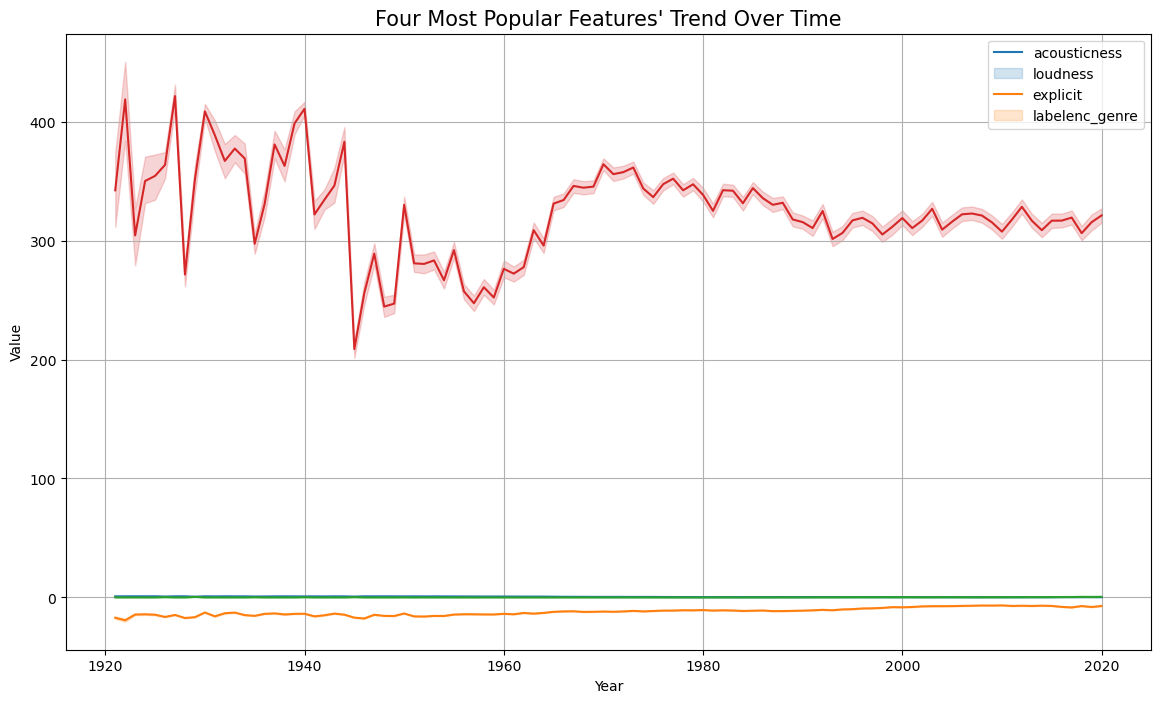

In [5]:
# create a simple line plot for initial analysis
plt.figure(figsize=(14,8))
plt.title("Four Most Popular Features' Trend Over Time", fontdict={"fontsize": 15})

# list of the four features you want to plot
features = ["acousticness", "loudness", "explicit", "labelenc_genre"]

# plot each feature as a line in the same plot
for feature in features:
    sns.lineplot(x='year', y=feature, data=df, label=feature)

# add labels and legend
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend(features)
plt.grid(True)
plt.show()

### Clearly normalization of the numeric features is required, but save the raw df for ARIMA/SARIMA since normalized features is only for the purpose of visualizing the trends/seasonalities in the data –– for ARIMA/SARIMA time series modeling, normalizing the features can cause a loss in the patterns

In [7]:
# create copy of original df
df2 = df.copy()
df2.head()

,acousticness,explicit,loudness,labelenc_genre
year,,,,
1928,0.995,0,-12.428,500
1928,0.994,0,-28.454,138
1928,0.604,0,-19.924,149
1928,0.995,0,-14.734,477
1928,0.990,0,-16.829,96


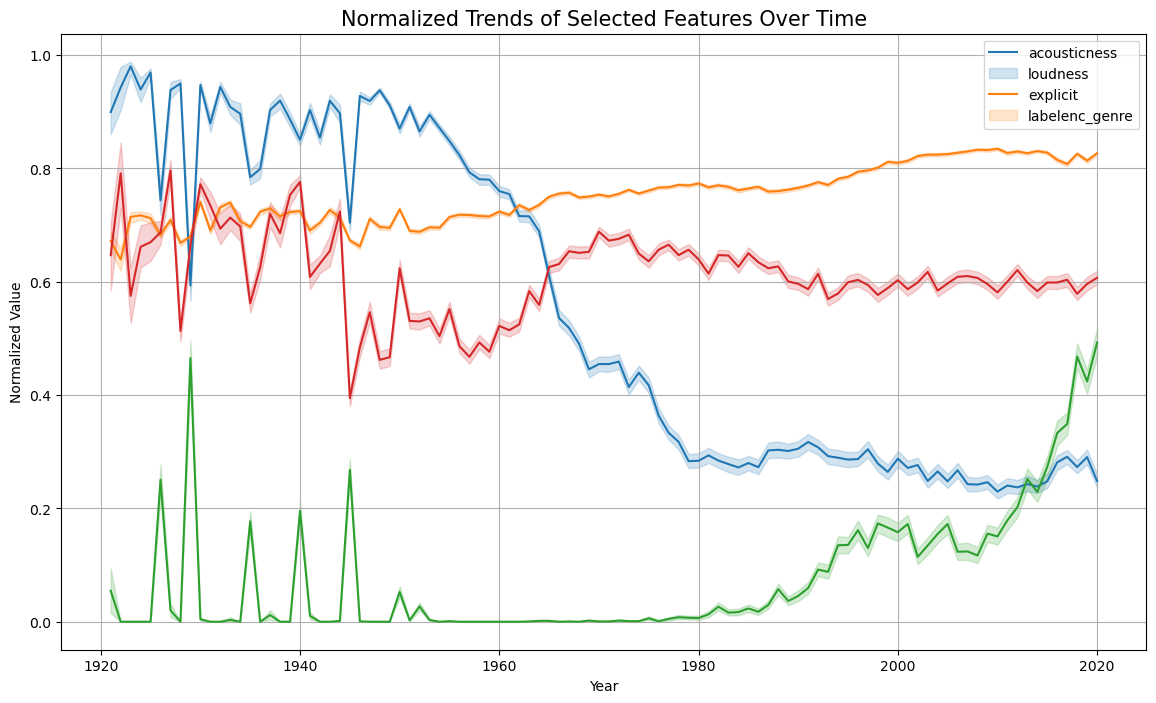

In [8]:
# create a MinMaxScaler instance to scale features between 0 and 1
scaler = MinMaxScaler()

# list of the features to scale
features = ["acousticness", "loudness", "explicit", "labelenc_genre"]

# scale the selected features
df[features] = scaler.fit_transform(df[features])

# create a line plot again with normalized features
plt.figure(figsize=(14,8))
plt.title("Normalized Trends of Selected Features Over Time", fontdict={"fontsize": 15})

# plot each feature
for feature in features:
    sns.lineplot(x='year', y=feature, data=df, label=feature)

# add labels and legend
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend(features)
plt.grid(True)
plt.show()

### Normalization went smoothly, but the legend doesn't align with the line plots

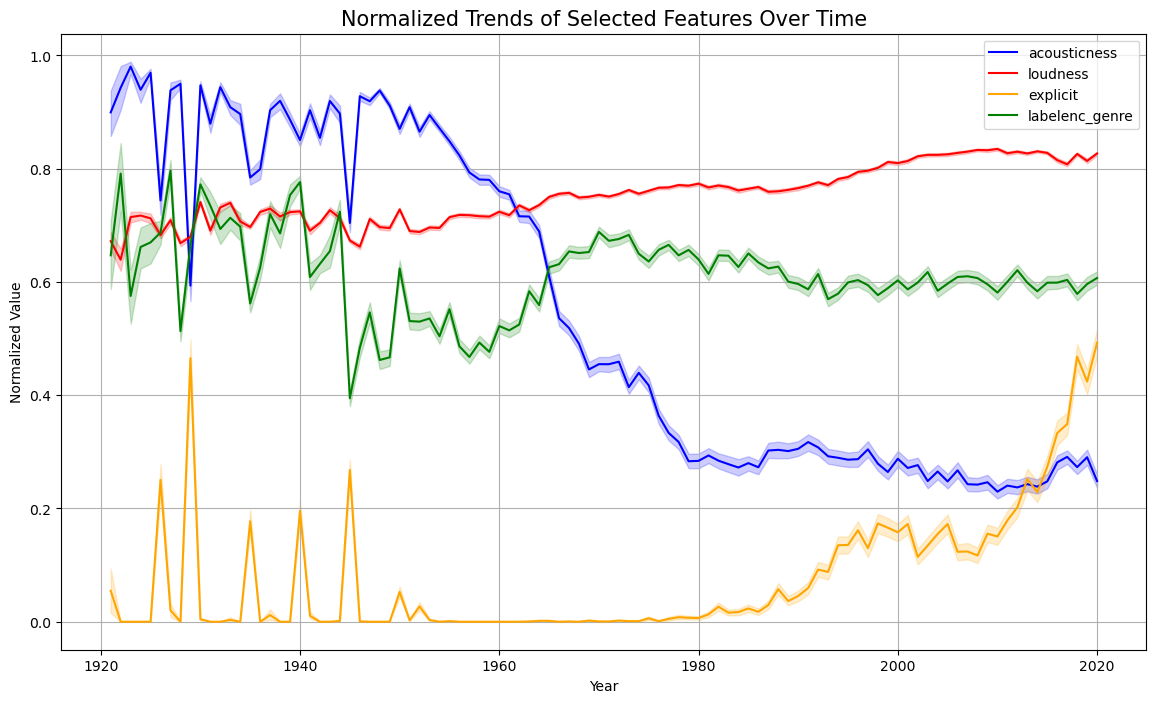

In [9]:
# Create a simple line plot for initial analysis
plt.figure(figsize=(14,8))
plt.title("Normalized Trends of Selected Features Over Time", fontdict={"fontsize": 15})

# Plot each feature separately
sns.lineplot(x='year', y="acousticness", data=df, label="acousticness", color="blue")
sns.lineplot(x='year', y="loudness", data=df, label="loudness", color="red")
sns.lineplot(x='year', y="explicit", data=df, label="explicit", color="orange")
sns.lineplot(x='year', y="labelenc_genre", data=df, label="labelenc_genre", color="green")

# Add labels and legend
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend(loc="best")
plt.grid(True)
plt.show()

### Normalization with aligned legend

In [10]:
df2.head()

,acousticness,explicit,loudness,labelenc_genre
year,,,,
1928,0.995,0,-12.428,500
1928,0.994,0,-28.454,138
1928,0.604,0,-19.924,149
1928,0.995,0,-14.734,477
1928,0.990,0,-16.829,96


In [11]:
# create separate dataframes for each individual feature with year as the index

acousticness_df = df2[['acousticness']].copy()
explicit_df = df2[['explicit']].copy()
loudness_df = df2[['loudness']].copy()
labelenc_genre_df = df2[['labelenc_genre']].copy()

acousticness_df.set_index(df2.index, inplace=True)
explicit_df.set_index(df2.index, inplace=True)
loudness_df.set_index(df2.index, inplace=True)
labelenc_genre_df.set_index(df2.index, inplace=True)

# verify 
print(acousticness_df.head())
print(explicit_df.head())
print(loudness_df.head())
print(labelenc_genre_df.head())

      acousticness
year              
1928         0.995
1928         0.994
1928         0.604
1928         0.995
1928         0.990
      explicit
year          
1928         0
1928         0
1928         0
1928         0
1928         0
      loudness
year          
1928   -12.428
1928   -28.454
1928   -19.924
1928   -14.734
1928   -16.829
      labelenc_genre
year                
1928             500
1928             138
1928             149
1928             477
1928              96


### The index year doesn't appear to be sorted, sorting is critical for time series forecasting

In [12]:
acousticness_df.sort_index(inplace=True)
explicit_df.sort_index(inplace=True)
loudness_df.sort_index(inplace=True)
labelenc_genre_df.sort_index(inplace=True)

# verify sorting
print(acousticness_df.head())
print(explicit_df.head())
print(loudness_df.head())
print(labelenc_genre_df.head())

      acousticness
year              
1921         0.994
1921         0.766
1921         0.732
1921         0.982
1921         0.941
      explicit
year          
1921         0
1921         0
1921         0
1921         0
1921         0
      loudness
year          
1921   -14.111
1921    -8.072
1921   -12.441
1921   -20.096
1921    -9.750
      labelenc_genre
year                
1921             409
1921             465
1921             500
1921              96
1921             500


### Index is sorted now

### ARIMA/SARIMA for Acousticness (non-normalized)

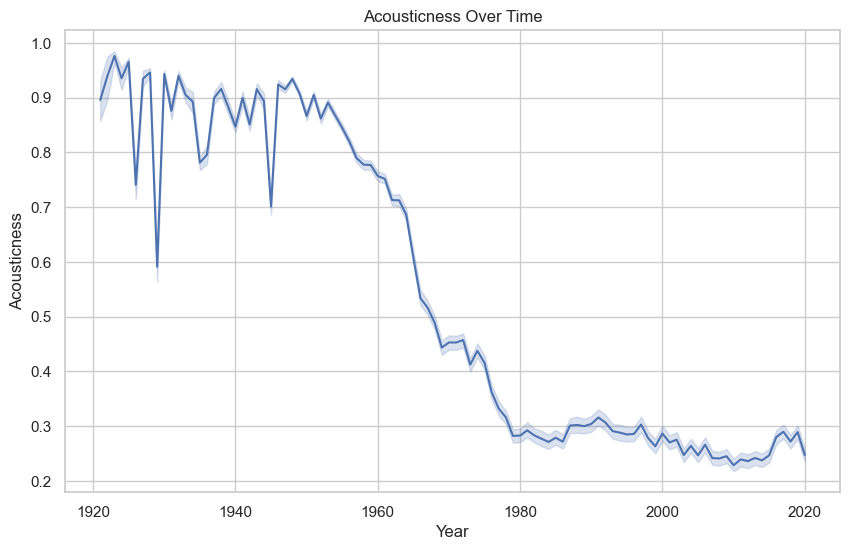

In [25]:
sns.set(style="whitegrid")

# plot line plot acousticness
plt.figure(figsize=(10, 6))
sns.lineplot(x=acousticness_df.index, y=acousticness_df['acousticness'])
plt.title('Acousticness Over Time')
plt.xlabel('Year')
plt.ylabel('Acousticness')
plt.show()

### Check for stationarity with ADF test: 

- Null hypothesis: 

    - acousticness time series is non-stationary (it has a unit root), meaning that different components of the 
      time series - trend, seasonality, and irregularity -- are present and change over time
      
- Alternative hypothesis:

    - acousticness time series is stationary (it does not have a unit root), meaning that it has a constant mean 
      and variance over time
      
- Decision Rule: 

    - If the p-value from the ADF test is greater than 0.05, we fail to reject the 
      null hypothesis (H₀). This implies the time series is non-stationary.
      
    - If the p-value is less than 0.05, we reject the null hypothesis and conclude that the time series is 
      stationary.


In [29]:
# perform Augmented Dickey-Fuller test to check for stationarity
result = adfuller(acousticness_df['acousticness'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print('We reject the null hypothesis and conclude that the time series is stationary.')
else:
    print('We fail to reject the null hypothesis and it is implied that the time series is non-stationary.')

ADF Statistic: -6.251127183673929
p-value: 4.451428416726128e-08
We reject the null hypothesis and conclude that the time series is stationary.
